In [1]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
import pandas as pd
pd.set_option('max_columns', 600)
pd.set_option('max_rows', 500)
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy, crf_viterbi_accuracy
from keras.models import Model, Input
from keras.layers import Dense, Bidirectional, Dropout, LSTM, TimeDistributed, Masking
from keras.utils import to_categorical, plot_model
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
from data_utils import read_data,data_convert,tag_id,MAX_SEQ_LEN,train_file_path,dev_file_path,test_file_path,id_tag
from albert_zh.extract_feature import BertVector

Using TensorFlow backend.


In [2]:
print(tag_id,MAX_SEQ_LEN,train_file_path,dev_file_path,test_file_path,id_tag)
#利用ALBERT生成词向量，pooling_strategy池化次略，有【REDUCE_MEAN，REDUCE_MAX，FIRST_TOKEN/CLS_TOKEN,LAST_TOKEN/SEP_TOKEN,NONE】
#本次采用NONE，也就是不采用池化策略，原本输出最后一层各个word的词向量；而其它的池化策略都是最终合并生成一个词向量，来代表整个句子的语义
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=MAX_SEQ_LEN)
#这里的0代理的是队列中的第一个元素，bert将每句话生成的词向量放入到队列中
word_encoder = lambda text: bert_model.encode([text])["encodes"][0]

{'O': 1, 'B-LOC': 2, 'I-LOC': 3, 'B-PER': 4, 'I-PER': 5, 'B-ORG': 6, 'I-ORG': 7} 128 ./data/example.train ./data/example.dev ./data/example.test {1: 'O', 2: 'B-LOC', 3: 'I-LOC', 4: 'B-PER', 5: 'I-PER', 6: 'B-ORG', 7: 'I-ORG'}



I:BERT_VEC:[graph:opt: 48]:model config: D:\学习\albert_BiLSTM_CRF\albert_zh/albert_tiny\albert_config_tiny.json
I:BERT_VEC:[graph:opt: 54]:build graph...


embedding_lookup_factorized. factorized embedding parameterization is used.
ln_type: postln
old structure of transformer.use: transformer_model,which use post-LN


I:BERT_VEC:[graph:opt:128]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:130]:freeze...
I:BERT_VEC:[graph:opt:133]:optimize...
I:BERT_VEC:[graph:opt:144]:write graph to a tmp file: ./tmp_graph11


### 利用keras构建模型架构

In [3]:
# Build model
def build_model(max_para_length, n_tags):
    # Bert Embeddings
    bert_output = Input(shape=(max_para_length, 312, ), name="bert_output")
    # LSTM model
    lstm = Bidirectional(LSTM(units=128, return_sequences=True), name="bi_lstm")(bert_output)
    drop = Dropout(0.1, name="dropout")(lstm)
    dense = TimeDistributed(Dense(n_tags, activation="softmax"), name="time_distributed")(drop)
    crf = CRF(n_tags)
    out = crf(dense)
    model = Model(inputs=bert_output, outputs=out)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(loss=crf.loss_function, optimizer='adam', metrics=[crf.accuracy])

    # 模型结构总结
    model.summary()
    #plot_model(model, to_file="albert_bi_lstm.png", show_shapes=True)

    return model

### 模型训练

In [4]:
# 模型训练
def train_model():
    # 读取训练集，验证集
    train_x, train_y = data_convert(word_encoder,train_file_path)
    dev_x, dev_y = data_convert(word_encoder,dev_file_path)
    

    # 模型训练
    model = build_model(MAX_SEQ_LEN, len(tag_id.keys())+1)
    history = model.fit(train_x, train_y, validation_data=(dev_x, dev_y), batch_size=16, epochs=10)

    model.save("albert_bilstm_crf.h5")
    return model,history
    

In [5]:
model,history=train_model()

sentences length: 20864 
last sentence:  思想自由是对自我而言，用中国传统的说法是有所为；兼容并包是指对待他人，要有所不为。
start ALBERT encoding
end ALBERT encoding
sentences length: 2318 
last sentence:  良性肿瘤、恶性肿瘤虽然只是一字之差，但两者有根本性的差别。
start ALBERT encoding
end ALBERT encoding
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_output (InputLayer)     (None, 128, 312)          0         
_________________________________________________________________
bi_lstm (Bidirectional)      (None, 128, 256)          451584    
_________________________________________________________________
dropout (Dropout)            (None, 128, 256)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 8)            2056      
_________________________________________________________________
crf_1 (CRF)                  (None, 128, 8)            152       
Total params: 453,79

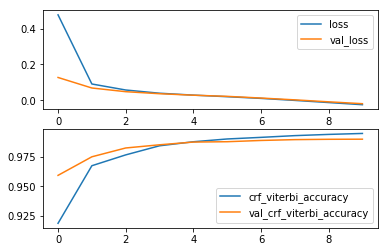

In [6]:
# 绘制loss和acc图像
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['crf_viterbi_accuracy'])
plt.plot(range(epochs), history.history['crf_viterbi_accuracy'], label='crf_viterbi_accuracy')
plt.plot(range(epochs), history.history['val_crf_viterbi_accuracy'], label='val_crf_viterbi_accuracy')
plt.legend()
plt.show()
plt.savefig("loss_accuracy.png")

### 模型在验证集上的表现

In [24]:
test_x, test_y = data_convert(word_encoder,dev_file_path)
print(test_x.shape,test_y.shape)
y = np.argmax(model.predict(test_x), axis=2)
pred_tags = []
for i in range(y.shape[0]):
    pred_tags.append([id_tag[id] for id in y[i] if id])
# 因为存在预测的标签长度与原来的标注长度不一致的情况，因此需要调整预测的标签
test_sents, test_tags = read_data(dev_file_path)
final_pred_tags = []
final_true_tags=[]
for test_tag, pred_tag in zip(test_tags, pred_tags):
    if len(test_tag) == len(pred_tag):
        final_pred_tags.append(test_tag)
        final_true_tags.append(test_tag)
    elif len(test_tag) < len(pred_tag):
        final_pred_tags.append(pred_tag[:len(test_tag)])
        final_true_tags.append(test_tag)
    else:
        final_pred_tags.append(pred_tag)
        final_true_tags.append(test_tag[:len(pred_tag)])

# 利用seqeval对测试集进行验证
print(classification_report(final_true_tags, final_pred_tags, digits=4))

sentences length: 2318 
last sentence:  良性肿瘤、恶性肿瘤虽然只是一字之差，但两者有根本性的差别。
start ALBERT encoding
end ALBERT encoding
(2318, 128, 312) (2318, 128, 8)
           precision    recall  f1-score   support

      PER     0.9863    0.9773    0.9818       882
      LOC     0.9862    0.9484    0.9669      1802
      ORG     0.9644    0.9447    0.9545       976

micro avg     0.9804    0.9544    0.9672      3660
macro avg     0.9804    0.9544    0.9672      3660



### 模型在测试集上的表现

In [19]:
# 模型在测试集上的表现，预测标签
test_x, test_y = data_convert(word_encoder,test_file_path)
print(test_x.shape,test_y.shape)
y = np.argmax(model.predict(test_x), axis=2)
pred_tags = []
for i in range(y.shape[0]):
    pred_tags.append([id_tag[id] for id in y[i] if id])
# 因为存在预测的标签长度与原来的标注长度不一致的情况，因此需要调整预测的标签
test_sents, test_tags = read_data(test_file_path)
final_pred_tags = []
final_true_tags=[]
for test_tag, pred_tag in zip(test_tags, pred_tags):
    if len(test_tag) == len(pred_tag):
        final_pred_tags.append(test_tag)
        final_true_tags.append(test_tag)
    elif len(test_tag) < len(pred_tag):
        final_pred_tags.append(pred_tag[:len(test_tag)])
        final_true_tags.append(test_tag)
    else:
        final_pred_tags.append(pred_tag)
        final_true_tags.append(test_tag[:len(pred_tag)])

# 利用seqeval对测试集进行验证
print(classification_report(final_true_tags, final_pred_tags, digits=4))

sentences length: 4636 
last sentence:  因此，村民进行民主选举的心态是在这样一种背景映衬下加以表现的，这无疑给该片增添了几分厚重的历史文化氛围。
start ALBERT encoding
end ALBERT encoding
(4636, 128, 312) (4636, 128, 8)
           precision    recall  f1-score   support

      PER     0.9861    0.9742    0.9801      1821
      LOC     0.9820    0.9593    0.9705      3464
      ORG     0.9731    0.9506    0.9617      2167

micro avg     0.9804    0.9604    0.9703      7452
macro avg     0.9804    0.9604    0.9703      7452

